# 複数量子ビットの場合

In [1]:
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import Fake7QPulseV1
from qiskit_dynamics import DynamicsBackend
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties,CouplingMap

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from qiskit import pulse,schedule ,transpile
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule
from qiskit.pulse import Schedule,Play,ControlChannel,Acquire,AcquireChannel,MemorySlot,DriveChannel,MeasureChannel

from qiskit_ibm_provider.job import job_monitor
from qiskit.circuit.library import RZGate,SXGate

前のセクションでは1つの量子ビットの演算に焦点を当てました．しかし，量子計算で重要であることは二つ以上の量子ビットをエンタングルさせることです．エンタングルをどのように実装しているのか覗いてみましょう！

## 2量子ビット(概略)
```{admonition} 注意
:class: warning
周波数可変型トランズモン量子ビットではこれと違う方法でiSWAPゲートを実現することで2量子ビットのゲート操作をしていますが，このセクションでは主にIBMで用いられている周波数固定型のトランズモン量子ビット(前のセクションで言うトランズモン量子ビット)に焦点を当てて，すべてパルスのみで実現する方法を述べていきます．<br>
また，このセクションは特に計算が難しいセクションです．そのため最初に読む際はこのセクションを飛ばし次の第三章に進んでも問題ありません．
```
### 何ができるようになりたいか？
実は2量子ビットの演算させ行うことができれば，たとえ2よりも多くの量子ビットになった場合も演算することができます．別の言い方をすれば，すべての演算は
\begin{align}
\{ X_{\pi/2}, Z_{\theta}, CNOT \}
\end{align}
の3つのゲートのみですべての演算を行うことができます．前のセクションでは$X_{\pi/2}, Z_{\theta}$の実装を行うことができました．よって，このセクションではCNOTゲートの実装方法を示していきます．<br>
以下の図はCNOTゲートは，これから説明するECRというゲートと，前のセクションまでで説明した$X_{\pi/2}, Z_{\theta}$ゲートのみで分解した時の図です．

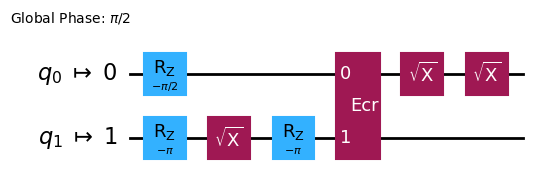

In [2]:
coupling_string = [[0, 1]]
CM = CouplingMap(coupling_string)
qc = QuantumCircuit(2)
qc.cx(0,1)

trans = transpile(qc, coupling_map=CM, basis_gates=['id', 'rz', 'sx', 'ecr']) 
trans.draw(output='mpl')

つまり，すべての演算を行うためには**ECR**ゲートが必要であることが分かります．ECRゲートとは以下の**CR**(Cross Resonance)ゲートの組み合わせでできています．Qiskit上では，$R_{ZX}$ゲートと呼ばれています．

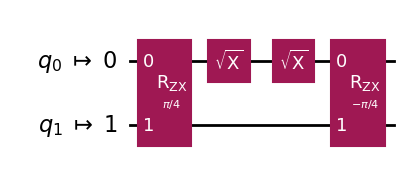

In [3]:
coupling_string = [[0, 1]]
CM = CouplingMap(coupling_string)
qc = QuantumCircuit(2)
qc.ecr(0,1)

trans = transpile(qc, coupling_map=CM, basis_gates=['id', 'rz', 'sx', 'rzx']) 
trans.draw(output='mpl')

以上の回路を見て分かるように，ECRゲートは，二つのSXゲートと，$CR_{\pm\pi/4}$で実現できていることが分かります．
つまり，2量子ビットでは，$CR_{\pm \pi/4}$のみの実装さえ行うことができればすべての量子計算を行うことができるのです．<br>
すなわち，すべての演算を行うために必要なゲートは
\begin{align}
\{ X_{\pi/2}, Z_{\theta}, CR_{\pm \pi/4} \}
\end{align}
のゲートのみを実装してキャリブレーションさえすればよいことが分かります．しかし後で分かるように$CR_{\pm\pi/4}$単体でのキャリブレーションではなく，エコーという方法を用いてキャリブレーションを行う必要性があると分かりますが，とりあえずはセクションの最終目標は以下にまとめることにします．
```{admonition} 最終目標
すべての演算を行うための最後のゲートである$CR_{\pm \pi/4}$ゲートを実装すること
```
です．

## 実装の理論
以下の構造のように二つの量子ビットが接続されており，量子ビット1にパルスを送る場合を考えましょう：
```{figure} ../../../images/multiple_qubit_2.png
:width: 500px
:align: center

二つの量子ビットが接続されており，量子ビット1にパルスを送る場合の回路図
```
この全体のハミルトニアンはそれぞれのトランズモン量子ビットと，量子ビット1にパルスを接続した項，そしてそれぞれの量子ビットの相互作用の項を加えたものになります：
\begin{align}
H = \underbrace{\left( -\frac{\hbar\omega_{1}}{2}\sigma_z\sigma_I + \hbar\Omega_1 V_1(t)\sigma_y\sigma_I \right)}_{量子ビット1} +\underbrace{\left( -\frac{\hbar\omega_{2}}{2}\sigma_I\sigma_z \right)}_{量子ビット2} + \underbrace{g\sigma_{y}\sigma_{y}}_{相互作用}
\end{align}
なお，$\sigma_I\sigma_z$のようにパウリ演算子が2つ連続しているものは，テンソル積を表しています．

```{admonition} テンソル積の復習
:class: dropdown
以下のように表します：
\begin{align}
\sigma_i \sigma_j = \sigma_i \otimes \sigma_j
\end{align}
これは例えば2量子ビットで1量子ビット目を$|a\rangle$，2量子ビット目を$|b\rangle$として表すと
\begin{align}
\sigma_i \sigma_j |ab\rangle = \left( \sigma_i|a\rangle \right) \otimes \left( \sigma_j|b\rangle \right)
\end{align}
となっており，例えば，$\sigma_i \sigma_j = \sigma_x \sigma_z$，$|a\rangle=|0\rangle, |b\rangle = |0\rangle$の時，
\begin{align}
\sigma_x \sigma_z |00\rangle &= \left( \sigma_x |0\rangle \right) \otimes \left( \sigma_z |0\rangle \right)\\
&=  |1\rangle \otimes |0\rangle = |10\rangle
\end{align}
となります．つまり，式()の1量子ビット目のみにかかるハミルトニアンのパウリ演算子は必ず$\sigma_j \otimes\sigma_I $となっていますし，2量子ビット目は$\sigma_I \otimes\sigma_j $となっています．
```


前のセクションよりも少しハミルトニアンは複雑になりましたが，やることは同様です．以下のシュレディンガー方程式を解いて，$|\psi(t)\rangle$を導出して$V(t)$の性質に応じてどのように量子ビットが変化をするかを考察するだけです．
\begin{align}
i\hbar \frac{\partial}{\partial t} |\psi(t)\rangle  = H |\psi(t)\rangle.
\end{align}
シュレディンガー方程式を解析して，どのようにして$CR_{\pm\pi/4}$を実現しているかを除いてみましょう！これから行う流れは以下の通りになっています．

```{image} ../../../images/cr_flow.png
:width: 600px
:align: center
```

### SW変換をする1
SW変換とはSchrieffer-Wolff変換のことを指します．SW変換とは，摂動論(ハミルトニアンの固有値を近似的に求める方法)の行列形式のことです．つまり，以下のように固有値と固有状態が分かっているハミルトニアンの項と，固有値と固有状態が解析できない微小な項(摂動項と言います)があった時，解析ができている項を利用して，近似的に解く方法です．
\begin{align}
H = \underbrace{H_0}_{固有値・固有状態が既知} + \underbrace{V}_{摂動項} 
\end{align}
以下にSchrieffer-Wolff変換の概要を述べています．
```{admonition}　Schrieffer-Wolff変換
:class: dropdown
\begin{align}
H = \underbrace{H_0}_{固有値・固有状態が既知} + \underbrace{V}_{摂動項} 
\end{align}
のように，固有値・固有状態が分かっている項と，解析できない摂動項があるハミルトニアンを考えます．ここで，摂動項の対角項は$H_0$に組み込むとして$V$は対角成分は含まれていないとします．また，$H_0$の固有値・固有状態を$E_i,|v_i\rangle$とします．<br>
すると，$H_0$は
\begin{align}
H_0 = \sum_i E_i |v_i\rangle\langle v_i|
\end{align}
と表すことができます．<br>
まずは以下のように行列$S$を定義します：
\begin{align}
S = - \sum_{i,j}\frac{\langle v_i|V|v_j\rangle}{E_i-E_j}|v_i\rangle\langle v_j|
\end{align}
ここで，Baker-Campbell-Hausdorffの関係式：
\begin{align}
e^{-S}H e^{S} = H + [H,S] + \frac{1}{2}[ [H,S],S ] + \mathcal{O}(S^3)
\end{align}
に$H=H_0+S$を代入すると，
\begin{align}
e^{-S}H e^{S} = \underbrace{H_0}_{H^{(0)}} + \underbrace{V+[H_0,S]}_{H^{(1)}} + \underbrace{ [V,S]+ \frac{1}{2}[ [H_0,S],S ] }_{H^{(2)}} + \cdots
\end{align}
となります．ただし，$[A,B]=AB-BA$を表します．ここで，$H^{(1)}$に関して．
\begin{align}
V+[H_0,S] &= V+ H_0 S - SH_0 \\
&= V+ \left( \sum_i E_i |v_i\rangle\langle v_i| \right)\left( - \sum_{i,j}\frac{\langle v_i|V|v_j\rangle}{E_i-E_j}|v_i\rangle\langle v_j| \right) - \left( - \sum_{i,j}\frac{\langle v_i|V|v_j\rangle}{E_i-E_j}|v_i\rangle\langle v_j| \right)\left( \sum_i E_i |v_i\rangle\langle v_i| \right)\\
&= V+ \left( - \sum_{i,j} E_i\frac{\langle v_i|V|v_j\rangle}{E_i-E_j}|v_i\rangle\langle v_j| \right) + \left( \sum_{i,j} E_j\frac{\langle v_i|V|v_j\rangle}{E_i-E_j}|v_i\rangle\langle v_j| \right)\\
&= V-\sum_{i,j} \langle v_i|V|v_j\rangle |v_i\rangle\langle v_j|\\
&= V-V = 0
\end{align}
となり，$H^{(1)}$の項は$0$になることが分かります．よって，$[H_0,S]=-V$であるため，
\begin{align}
e^{-S}H e^{S} &= \underbrace{H_0}_{H^{(0)}} +  \underbrace{ [V,S]+ \frac{1}{2}[ [H_0,S],S ] }_{H^{(2)}} + \mathcal{O}(S^3)\\
&= H_0+ \frac{1}{2}[V,S] +  \mathcal{O}(S^3)
\end{align}
になり，$e^{-S}H e^{S}$は$H$を$\mathcal{O}(S^2)$の精度で近似できていることが分かります．よって，
\begin{align}
H \sim e^{-S}H e^{S}
\end{align}
とすることが可能で，この変換をSchrieffer-Wolff変換と言います．
```

#### 行列$S$を求める
ここから先はこのSW変換を利用してハミルトニアンを解析していきます．以下のようにハミルトニアンを各項に分けます：
\begin{align}
H &= \underbrace{\left( -\frac{\hbar\omega_{1}}{2}\sigma_z\sigma_I + \hbar\Omega_1 V_1(t)\sigma_y\sigma_I \right)}_{量子ビット1} +\underbrace{\left( -\frac{\hbar\omega_{2}}{2}\sigma_I\sigma_z \right)}_{量子ビット2} + \underbrace{g\sigma_{y}\sigma_{y}}_{相互作用}\\
&= \underbrace{ -\frac{\hbar\omega_{1}}{2}\sigma_z\sigma_I -\frac{\hbar\omega_{2}}{2}\sigma_I\sigma_z }_{H_0} + \underbrace{  \hbar\Omega_1 V_1(t)\sigma_y\sigma_I }_{H_d} + \underbrace{ g\sigma_{y}\sigma_{y} }_{H_{\text{int}}}
\end{align}

ここで，$H_0$は$\sigma_z$のみを含んでおり，それぞれの固有状態と固有値が得られていることが分かります．
\begin{align}
H_0 |00\rangle &= -\frac{\hbar}{2} \left( \omega_{1}+\omega_{2}\right) |00\rangle =: E_{00}|00\rangle \\
H_0 |01\rangle &= -\frac{\hbar}{2} \left( \omega_{1}-\omega_{2}\right) |01\rangle =: E_{01}|01\rangle\\
H_0 |10\rangle &= -\frac{\hbar}{2} \left( -\omega_{1}+\omega_{2}\right) |10\rangle =: E_{10}|10\rangle\\
H_0 |11\rangle &= -\frac{\hbar}{2} \left( -\omega_{1}-\omega_{2}\right) |11\rangle =: E_{11}|11\rangle
\end{align}
よって，$H_0$は固有値と固有状態が分かっており，一度$H_d$の項は置いておくと，摂動項は$H_{\text{int}}$です．よって，行列$S$を求めると
\begin{align}
S &= -\sum_{k,l} \frac{\langle k | H_{\text{int}} | l\rangle }{E_{k}-E_{l}}|k\rangle\langle l|, \quad k,l \in \{ 00,01,10,11 \}\\
&= -\sum_{k,l} \frac{\langle k | g\sigma_{y}\sigma_{y} | l\rangle }{E_{k}-E_{l}}|k\rangle\langle l|
\end{align}
となります．よってこれより行列の計算をすると，
\begin{align}
S = \frac{g}{\hbar}
\begin{bmatrix}
0 & 0 & 0 & 1/(\omega_1+\omega_2)\\
0 & 0 & -1/(\omega_1-\omega_2) & 0\\
0 & 1/(\omega_1-\omega_2) & 0 & 0\\
1/(\omega_1+\omega_2) & 0 & 0 & 0
\end{bmatrix}
\end{align}
となります．ここで，通常量子ビットの周波数は4GHzほどに対して，各量子ビットの周波数の差は0.1GHzほどになるため，$\omega_1-\omega_2 \sim 0.1$GHzに対して，$\omega_1+\omega_2\sim 8$GHzほどになり，約100倍のずれがあることがあることが分かります，$1/(\omega_1+\omega_2)$の項は$1/(\omega_1-\omega_2)$に比べて十分に小さいため，無視することができます．<br>
よって，行列$S$は$\Delta = \omega_1-\omega_2$として，
```{admonition} 行列S

\begin{align}
S = \frac{g}{\hbar\Delta}
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
\end{align}
```
となります．$S$を求めることができたため次にハミルトニアンをSW変換して近似をしていきます．

#### ハミルトニアンを変換する
よって，変換後のハミルトニアンを$H'$とすると，
\begin{align}
H' \sim e^{-S} H  e^{S} =  e^{-S} \left( H_0  + H_{\text{int}} + H_d \right)  e^{S}
\end{align}
となります．ここで，SW変換で説明をしたように，$H_0 +  H_{\text{int}}$の部分は
\begin{align}
e^{-S} \left( H_0 +  H_{\text{int}} \right)e^{S} \approx  H_0 + \frac{1}{2}[ H_{\text{int}}, S ]
\end{align}
となり，$[ H_{\text{int}}, S ]$の部分を計算すると，
\begin{align}
[ H_{\text{int}}, S ] &= H_{\text{int}} S - S H_{\text{int}}\\
&= 
\frac{g^2}{\hbar\Delta}
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 2 & 0 & 0\\
0 & 0 & -2 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
=\frac{g^2}{\hbar\Delta} \left( \sigma_z\sigma_I - \sigma_I\sigma_z \right)
\end{align}
となるため，$H_0$を代入すると，
\begin{align}
e^{-S} \left( H_0 +  H_{\text{int}} \right)e^{S} &=H_0 + \frac{1}{2}[ H_{\text{int}}, S ] \\
&= -\frac{\hbar\omega_{1}}{2}\sigma_z\sigma_I -\frac{\hbar\omega_{2}}{2}\sigma_I\sigma_z +\frac{1}{2}\frac{g^2}{\hbar\Delta} \left( \sigma_z\sigma_I - \sigma_I\sigma_z \right)
\end{align}
となります．<br>
次に，$H_d$の項に関しても同様にして変換をします．BCH公式を用いて展開すると，
\begin{align}
e^{-S} H_d e^{S} = H_d + [H_d,S] + \frac{1}{2}[[H_d,S],S] + \mathcal{O}(S^3)
\end{align}
となります．この行列$S$は$H_{\text{int}}$に対応しているものであり，$H_d$に対応する行列$S$ではないため，消去できる項はなくただ単にBCH公式を使っています．この場合は二次以上の項を無視すると，
\begin{align}
e^{-S} H_d e^{S}  \sim H_d + [H_d,S]
\end{align}
となり，
\begin{align}
[H_d,S] &= H_d S - S H_d \\
&= \hbar\Omega_1V_1(t)\frac{g}{\hbar\Delta}
\begin{bmatrix}
0 & -i & 0 & 0\\
i & 0 & 0 & 0\\
0 & 0 & 0 & i\\
0 & 0 & -i & 0
\end{bmatrix}
= \hbar\Omega_1V_1(t)\frac{g}{\hbar\Delta}\sigma_z \sigma_y
\end{align}
であるため，
\begin{align}
e^{-S} H_d e^{S} =\hbar\Omega_1V_1(t)\sigma_y\sigma_I +  \hbar\Omega_1V_1(t)\frac{g}{\hbar\Delta}\sigma_z \sigma_y
\end{align}
となります．よって以下のようにハミルトニアンを近似することができます．

```{admonition} SW変換によるハミルトニアンの近似

\begin{align}
H \sim H'&:=  e^{-S} H  e^{S}  \\
&=  e^{-S} (H_0 + H_{\text{int}})e^{S} + e^{-S} H_d e^{S} \\
&=-\frac{\hbar\omega_{1}}{2}\sigma_z\sigma_I -\frac{\hbar\omega_{2}}{2}\sigma_I\sigma_z +\frac{1}{2}\frac{g^2}{\hbar\Delta} \left( \sigma_z\sigma_I - \sigma_I\sigma_z \right)\\
&\quad +\hbar\Omega_1V_1(t)\sigma_y\sigma_I +  \hbar\Omega_1V_1(t)\frac{g}{\hbar\Delta}\sigma_z \sigma_y\\
&= -\frac{\hbar}{2}\left( \omega_1- \frac{g^2}{\hbar^2\Delta} \right)\sigma_z\sigma_I -\frac{\hbar}{2}\left( \omega_2 + \frac{g^2}{\hbar^2\Delta} \right)\sigma_I\sigma_z\\
&\quad +\hbar\Omega_1V_1(t)\sigma_y\sigma_I +  \hbar\Omega_1V_1(t)\frac{g}{\hbar\Delta}\sigma_z \sigma_y
\end{align}
```
つまり，このハミルトニアンから得られるシュレディンガー方程式：
\begin{align}
i\hbar \frac{d}{dt}|\psi(t)\rangle = H' |\psi(t)\rangle
\end{align}
を解析させすればよくなることが分かります．しかしまだ$\sigma_z$などの成分が含まれているため，前のセクションと同様にして回転系に入りましょう！

### 回転系に入る
ここでは，
\begin{align}
\tilde{\omega}_1 &=  \omega_1- \frac{g^2}{\hbar^2\Delta} \\
\tilde{\omega}_2 &=  \omega_2 + \frac{g^2}{\hbar^2\Delta} 
\end{align}
と定義をします．このセクションでは量子ビット1,2がそれぞれ$\tilde{\omega}_2$で回転している場合を考えます．つまり回転演算子は
\begin{align}
\hat{U}_{\text{rf}}(t) = \exp\left[ -i \frac{\tilde{\omega}_2}{2}t\sigma_z\sigma_I \right]\exp\left[ -i \frac{\tilde{\omega}_2}{2}t\sigma_I\sigma_z \right]
\end{align}
となり，回転系でのハミルトニアンは，前のセクションで導出したように，
\begin{align}
\tilde{H}' = i\hbar\dot{\hat{U}}_{\text{rf}}(t)\hat{U}_{\text{rf}}^{\dagger}(t) + \hat{U}_{\text{rf}}(t)H'\hat{U}_{\text{rf}}^\dagger(t)
\end{align}
で与えれるため，これを計算すると，
\begin{align}
\tilde{H}' &:= -\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right)\sigma_z\sigma_I + \hbar\Omega_1V_1(t)\left( \sigma_y\cos(\tilde{\omega}_2 t)- \sigma_x \sin(\tilde{\omega}_2 t) \right)\sigma_I\\
&\quad + \hbar\Omega_1V_1(t)\frac{g}{\hbar\Delta}\sigma_z \left( \sigma_y\cos(\tilde{\omega}_2 t)- \sigma_x \sin(\tilde{\omega}_2 t) \right)
\end{align}
となります．ここで，先ほどの量子ビット一つの場合と同様にして1つ目の量子ビットに対して
\begin{align}
V_1(t) =  V_0 \exp\left[ -\frac{(t-t_0)^2}{2\sigma^2} \right]\sin(\omega_d t+ \phi)
\end{align}
というパルスを打ち込むとします．なお，ここからは先は簡単のため
\begin{align}
A(t) :=  V_0 \exp\left[ -\frac{(t-t_0)^2}{2\sigma^2} \right]
\end{align}
と表記します．ここで，
\begin{align}
V_1(t)\left( \sigma_y\cos(\tilde{\omega}_2 t)- \sigma_x \sin(\tilde{\omega}_2 t) \right)
\end{align}
の部分に注目し，量子ビットが1つの場合に導出した回転波近似から得られる式：
\begin{align}
\sin(\omega_d t+ \phi)\left( \sigma_y\cos(\tilde{\omega}_2 t)- \sigma_x \sin(\tilde{\omega}_2 t) \right) \approx -\frac{1}{2}\left( \sin(\tilde{\omega}_2 t-\omega_d t+\phi)\sigma_y +\cos(\tilde{\omega}_2 t-\omega_d t+\phi)\sigma_x \right)
\end{align}
より，
\begin{align}
\tilde{H}' &= -\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right)\sigma_z\sigma_I - \hbar\Omega_1\frac{1}{2}A(t)\left( \sin(\tilde{\omega}_2 t-\omega_d t+\phi)\sigma_y +\cos(\tilde{\omega}_2 t-\omega_d t+\phi)\sigma_x \right) \sigma_I\\
&\quad - \hbar\Omega_1\frac{g}{\hbar\Delta}\sigma_z \frac{1}{2}A(t)\left( \sin(\tilde{\omega}_2 t-\omega_d t+\phi)\sigma_y +\cos(\tilde{\omega}_2 t-\omega_d t+\phi)\sigma_x \right)
\end{align}
となります． **打つパルスの周波数$\omega_d$を$\tilde{\omega}_2$** にします．すると，$\omega_d = \tilde{\omega}_2$であるため，
\begin{align}
\tilde{H}' &= -\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right)\sigma_z\sigma_I- \hbar\Omega_1\frac{1}{2}A(t) ( \sin(\phi)\sigma_y + \cos(\phi)\sigma_x )\sigma_I\\
&\quad - \hbar\Omega_1\frac{g}{\hbar\Delta}\sigma_z \frac{1}{2}A(t)( \sin(\phi)\sigma_y + \cos(\phi)\sigma_x )
\end{align}
となります．そして，先に答えを言ってしまうとCRゲートを実現させるときは$\phi=0$とします．よって，
\begin{align}
\tilde{H}' = -\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right)\sigma_z\sigma_I- \hbar\Omega_1\frac{1}{2}A(t) \sigma_x \sigma_I- \hbar\Omega_1\frac{g}{\hbar\Delta}\sigma_z \frac{1}{2}A(t)\sigma_x
\end{align}
となります．以上をまとめて先に答えを提示すると，CRゲートは以下で実現されます：
```{admonition} CRゲートの実現方法
1つ目の量子ビットに対して$\omega_d = \tilde{\omega}_2$,$\phi=0$となる次のパルスを打ちます．
\begin{align}
V_1(t) =  A(t)\sin(\tilde{\omega}_2 t)
\end{align}
そして，キャリブレーションを行い，$CR_{\theta}$が実現できるパルスの振幅を記録します．
```

### 量子ビット1のみにSW変換をする
先ほどの回転系でのハミルトニアンは
\begin{align}
\tilde{H}' = \underbrace{\left(-\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right)\sigma_z- \hbar\Omega_1\frac{1}{2}A(t) \sigma_x\right)}_{量子ビット1のみの作用}\sigma_I - \underbrace{\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t)\sigma_z \sigma_x}_{相互作用をする項}
\end{align}
と書くことができます．ここで，一端，相互作用の項を忘れて，量子ビット1のみの作用を取り出してSW変換を計算します．<br>
1つ目の量子ビットの項のみを取り出すと
\begin{align}
\underbrace{-\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right)\sigma_z}_{\tilde{H}_0} + \underbrace{\left(- \hbar\Omega_1\frac{1}{2}A(t) \sigma_x\right)}_{\tilde{H}_d}
\end{align}
となります．ここで，$\tilde{H}_0$の固有値・固有状態は次のように求まります．
\begin{align}
\tilde{H}_0|0\rangle &= -\frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right) |0\rangle =: E_0 |0\rangle\\
\tilde{H}_0|1\rangle &= \frac{\hbar}{2}\left( \tilde{\omega}_1 - \tilde{\omega}_2 \right) |1\rangle =: E_1 |1\rangle
\end{align}
よって．$\tilde{H}_d$の部分を摂動項としてSW変換をして対角化します．<br>
まず行列$S$を求めると
```{admonition} 行列$S$
\begin{align}
S &= -\sum_{i,j}\frac{ \langle i|\tilde{H}_d |j\rangle }{E_i-E_j}|i\rangle \langle j|, \quad \{i,j\} = \{ 0,1 \}\\
&= \frac{1}{\hbar(\tilde{\omega}_1 - \tilde{\omega}_2)}\left(- \hbar\Omega_1\frac{1}{2}A(t)\right)
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\\
&= \frac{i}{\hbar\tilde{\Delta}}\left(- \hbar\Omega_1\frac{1}{2}A(t)\right)
\sigma_y,\quad ただし，\tilde{\Delta} = \tilde{\omega}_1 - \tilde{\omega}_2 とした．
\end{align}
```
となります．そして近似したハミルトニアンは
\begin{align}
\tilde{H}' \sim \tilde{H}'' := \left( \tilde{H}_0+ \frac{1}{2}[ \tilde{H}_d, S ] \right)\sigma_I -\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t) \left( e^{-S}\sigma_z e^{S}\right)\sigma_x 
\end{align}
となります．ただし，オーダーは$ \mathcal{O}(\hbar\Omega_1^3)$です．ここで，
\begin{align}
[ \tilde{H}_d, S ]  &= \frac{1}{4}\hbar\Omega_1^2 A^2(t)\frac{i}{\hbar\tilde{\Delta}}[\sigma_x,\sigma_y]\\
&= -\frac{1}{2}\hbar\Omega_1^2 A^2(t)\frac{1}{\hbar\tilde{\Delta}}\sigma_z
\end{align}
であることと，BCHの関係式より，
\begin{align}
e^{-S}\sigma_z e^{S} &= \sigma_z + [ \sigma_z,S ] + \mathcal{O}(\hbar\Omega_1^2)\\
&= \sigma_z + \frac{i}{\hbar\tilde{\Delta}}\left(- \hbar\Omega_1\frac{1}{2}A(t)\right) [\sigma_z,\sigma_y]+ \mathcal{O}(\hbar\Omega_1^2)\\
&= \sigma_z +  \frac{2}{\hbar\tilde{\Delta}}\left(- \hbar\Omega_1\frac{1}{2}A(t)\right) \sigma_x + \mathcal{O}(\hbar\Omega_1^2)
\end{align}
となることよりそれぞれ代入すると，
\begin{align}
\tilde{H}'' &= \left(-\frac{\hbar}{2}\tilde{\Delta} -\frac{1}{4}\hbar\Omega_1^2 A^2(t)\frac{1}{\hbar\tilde{\Delta}} \right) \sigma_z\sigma_I -\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t) \left( \sigma_z +  \frac{2}{\hbar\tilde{\Delta}}\left(- \hbar\Omega_1\frac{1}{2}A(t)\right) \sigma_x \right)\sigma_x\\
&=\left(-\frac{\hbar}{2}\tilde{\Delta} -\frac{1}{4}\hbar\Omega_1^2 A^2(t)\frac{1}{\hbar\tilde{\Delta}} \right) \sigma_z\sigma_I + \left( -\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t) \right)\sigma_z \sigma_x + \left( \hbar\Omega_1^2 \frac{g A(t)}{\hbar^2 \Delta \tilde{\Delta}} \right)\sigma_x\sigma_x
\end{align}

となりますが，$\mathcal{O}\left(\hbar\Omega_1/\Delta\right)^2$は$\mathcal{O}\left(\hbar\Omega_1/\Delta\right)$にくらべて十分に小さいので，
\begin{align}
H'' \sim H''' := \left(-\frac{\hbar}{2}\tilde{\Delta} -\frac{1}{4}\hbar\Omega_1^2 A^2(t)\frac{1}{\hbar\tilde{\Delta}} \right) \sigma_z\sigma_I + \left( -\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t) \right)\sigma_z \sigma_x
\end{align}
と近似できます．ここで，最後に1つ目の量子ビットが$\tilde{\Delta}$で回転する回転系に移ります．回転演算子は1量子ビットで説明したように
\begin{align}
\hat{U}_{\text{rf}}(t) = \exp\left( -i\frac{\tilde{\Delta}t}{2}\sigma_z\sigma_I \right)
\end{align}
で表されます．1量子ビットの場合で説明したように，回転系のハミルトニアンは
\begin{align}
i\hbar \dot{\hat{U}}_{\text{rf}}(t)\hat{U}^{\dagger}_{\text{rf}}(t) + \hat{U}_{\text{rf}}(t) H \hat{U}^{\dagger}_{\text{rf}}(t)
\end{align}
となるため，この回転系のハミルトニアンに$\hat{U}_{\text{rf}}(t)$を代入すると，
\begin{align}
\left(-\frac{1}{4}\hbar\Omega_1^2 A^2(t)\frac{1}{\hbar\tilde{\Delta}} \right) \sigma_z\sigma_I + \left( -\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t) \right)\sigma_z \sigma_x
\end{align}
となります．なお，導出は以下にまとめています．

よって，回転系での時間発展は回転系での初期状態を$|\psi_{\text{rf}}(0)\rangle$とすると，時刻$t$での状態$|\psi_{\text{rf}}(t)\rangle$は
\begin{align}
|\psi_{\text{rf}}(t)\rangle = \exp\left[ \frac{1}{i\hbar}\left\{ \int_0^{t}\left(-\frac{1}{4}\hbar\Omega_1^2 A^2(t')\frac{1}{\hbar\tilde{\Delta}} \right)dt' \sigma_z\sigma_I + \int_0^{t}\left( -\hbar\Omega_1\frac{g}{\hbar\Delta}\frac{1}{2}A(t') \right)dt'\sigma_z \sigma_x  \right\}\right]|\psi_{\text{rf}}(0)\rangle
\end{align}
となります．$t$が$\sigma,t_0$よりも十分に大きいとするとガウス積分より
\begin{align}
\int_0^{t} A(t')dt' &= \int_0^{t}V_0 \exp\left[ -\frac{(t'-t_0)^2}{2\sigma^2} \right]dt' =V_0\sigma\sqrt{2\pi}\\
\int_0^{t} A^2(t')dt' &=\int_0^{t}V_0^2 \exp\left[ -\frac{(t'-t_0)^2}{\sigma^2} \right]dt'=V_0^2\sigma\sqrt{\pi}\\
\end{align}
となるため，
\begin{align}
\theta_{ZI} := -V_0^2 \frac{\hbar\Omega_1^2 \cdot \sigma\sqrt{\pi}}{2\hbar^2 \tilde{\Delta}}, \quad \theta_{ZX}:= V_0 \frac{\hbar\Omega_1^2 g\sigma\sqrt{2\pi}}{\hbar^2\Delta}
\end{align}
とすると，
\begin{align}
|\psi_{\text{rf}}(t)\rangle = \exp\left( -i\frac{\theta_{ZI}}{2}\sigma_z\sigma_I-i\frac{\theta_{ZX}}{2}\sigma_z\sigma_x \right)|\psi_{\text{rf}}(0)\rangle
\end{align}
となります．ここで，$\theta_{ZI}$の成分を除去することができればCRゲート：
\begin{align}
|\psi_{\text{rf}}(t)\rangle = \exp\left( -i\frac{\theta_{ZX}}{2}\sigma_z\sigma_x \right)|\psi_{\text{rf}}(0)\rangle
\end{align}
を実現することができます．

## どのようにして不要な項を消すか？
ここからはどのようにして不要な項である$\theta_{ZI}$の成分を消去することができるかを考えていきます．実は

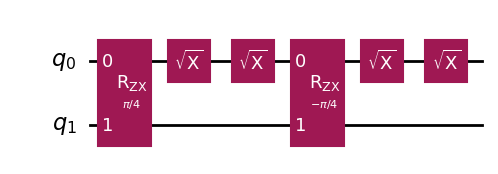

In [4]:
qc = QuantumCircuit(2)
qc.rzx(np.pi/4,0,1)
qc.sx(0)
qc.sx(0)
qc.rzx(-np.pi/4,0,1)
qc.sx(0)
qc.sx(0)
qc.draw(output='mpl')

という回路は，この$\theta_{ZX}$の項を作用を打ち消ししつつ，全体として$CR_{\pi/2}$を実現することができています．(このことを**エコー**と呼びます．)<br>
以下では実際に計算をして$\theta_{ZX}$の項が消えていることと，全体として$CR_{\pi/2}$を実現できていることを確認します．

$CR_{\pi/4}$を実現するためには
\begin{align}
\theta_{ZX}:= V_0 \frac{\hbar\Omega_1^2 g\sigma\sqrt{2\pi}}{\hbar^2\Delta} = \frac{\pi}{4}
\end{align}
を満たしている必要があるため，
\begin{align}
\theta_{ZI} &:= -V_0^2 \frac{\hbar\Omega_1^2 \cdot \sigma\sqrt{\pi}}{2\hbar^2 \tilde{\Delta}} = C\cdot \frac{\pi^2}{16}\\
C&:= - \frac{\hbar^2\Delta^2}{\hbar\Omega_1^2 g^2 \sigma 4\sqrt{\pi}\tilde{\Delta}}
\end{align}
となります．ただし，$C$はパルスの形によらない定数です．<br>また，
$CR_{-\pi/4}$を実現するためには
\begin{align}
\theta_{ZX}:= V_0 \frac{\hbar\Omega_1^2 g\sigma\sqrt{2\pi}}{\hbar^2\Delta} = -\frac{\pi}{4}
\end{align}
を満たしている必要があるため，
\begin{align}
\theta_{ZI} &:= -V_0^2 \frac{\hbar\Omega_1^2 \cdot \sigma\sqrt{\pi}}{2\hbar^2 \tilde{\Delta}} = C\cdot \frac{\pi^2}{16}
\end{align}
となり，$\theta_{ZI}$の項は$CR_{\pm\pi/4}$でそれぞれ一致していることが分かります．よって，それぞれ作用させると
\begin{align}
&\underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\cdot \underbrace{\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I+\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{-\pi/4}ゲート} \cdot \underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\\
&\quad \cdot \underbrace{\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I-\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{\pi/4}ゲート}|\psi_{\text{rf}}(0)\rangle
\end{align}

となります．ここで，以下の公式を利用して計算していきます．

```{admonition} 行列指数関数の性質3
行列$A,B$があり，交換関係$[A,B]= AB-BA = 0$を満たしているとき
\begin{align}
\exp( A+B ) = \exp(A)\cdot \exp(B) = \exp(B)\cdot \exp(A)
\end{align}
が成立する．
```
ここで，
\begin{align}
[\sigma_z\otimes\sigma_I,\sigma_z\otimes\sigma_x]&= (\sigma_z\otimes\sigma_I)(\sigma_z\otimes\sigma_x)-(\sigma_z\otimes\sigma_x)(\sigma_z\otimes\sigma_I)\\
&=(\sigma_z\cdot \sigma_z)\otimes (\sigma_I\cdot\sigma_x)-(\sigma_z\cdot \sigma_z)\otimes (\sigma_x\cdot\sigma_I)\\
&=0
\end{align}
となるため，行列指数関数の性質より
\begin{align}
\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\pm\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right) &= \exp\left(-\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\right)\cdot \exp\left(\pm\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)\\
&=\exp\left(\pm\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)\cdot\exp\left(-\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\right)
\end{align}
となります．少々式が長くなりますが，各ゲートの行列は
\begin{align}
&\underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\cdot \underbrace{\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I+\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{-\pi/4}ゲート} \cdot \underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\\
&\quad\cdot \underbrace{\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I-\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{\pi/4}ゲート}\\
&=\underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\cdot \underbrace{\exp\left(\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)\cdot\exp\left(-\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\right) }_{CR_{-\pi/4}ゲート} \cdot \underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\\
&\quad\cdot \underbrace{\exp\left(-\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\right)\cdot\exp\left(-\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{\pi/4}ゲート}\\
\end{align}
となります．

ここで，
\begin{align}
\exp\left(-\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\right)\cdot \exp(-\frac{i}{2}\pi \sigma_x\sigma_I )\cdot \exp\left(-\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I\right) = \exp(-\frac{i}{2}\pi \sigma_x\sigma_I )
\end{align}
となり，
\begin{align}
\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )\exp\left(\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)\cdot\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )\cdot\exp\left(-\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)= \exp\left(-\frac{i}{2}\frac{\pi}{2}\sigma_z\sigma_x \right)
\end{align}
となります．なお，それぞれの導出は，第一章でも登場した以下の行列指数関数2の公式を利用すると簡単に導出できます．

```{admonition} 行列指数関数の性質2
パウリ行列$\sigma_j,\sigma_k$に対して
\begin{align}
\exp\left( -\frac{i}{2}\theta \sigma_j\otimes\sigma_k \right) = \cos( \theta/2 )\sigma_I\otimes \sigma_I - i \sin(\theta/2) \sigma_j\otimes\sigma_k
\end{align}
となります．なお，証明は以下の通りです：<br>
指数関数を展開すると
\begin{align}
&\exp\left( -\frac{i}{2}\theta \sigma_j\otimes\sigma_k \right)\\
\quad& = \sigma_I \otimes \sigma_I -\frac{i}{2}\theta \sigma_j\otimes\sigma_k + \frac{1}{2}\left( -\frac{i}{2}\theta  \sigma_j\otimes\sigma_k \right)^2 +\frac{1}{6}\left( -\frac{i}{2}\theta  \sigma_j\otimes\sigma_k \right)^3+ \cdots\\
\quad& = \sigma_I \otimes \sigma_I -\frac{i}{2}\theta \sigma_j\otimes\sigma_k - \frac{1}{2}\left(  \frac{\theta}{2} \right)^2 \sigma_I \otimes \sigma_I +i\frac{1}{6}\left(  \frac{\theta}{2} \right)^3\sigma_j\otimes\sigma_k + \cdots\\
\quad& = \left\{  1 - \frac{1}{2}\left(  \frac{\theta}{2} \right)^2 + \cdots  \right\}\sigma_I\otimes \sigma_I -i \left\{ \frac{\theta}{2}- \frac{1}{6}\left(  \frac{\theta}{2} \right)^3+ \cdots \right\}\sigma_j\otimes\sigma_k\\
\quad &= \cos( \theta/2 )\sigma_I\otimes \sigma_I - i \sin(\theta/2) \sigma_j\otimes\sigma_k
\end{align}
となります．ただし，パウリ行列の二乗は単位行列$\sigma_I$であるという性質より
\begin{align}
\left( \sigma_j\otimes\sigma_k \right)^2 &= \left( \sigma_j\otimes\sigma_k \right)\left( \sigma_j\otimes\sigma_k \right)\\
&= \left( \sigma_j\sigma_j \right)\otimes \left( \sigma_k\sigma_k \right)\\
&= \sigma_I\otimes\sigma_I
\end{align}
となることを利用しています．
```
よってまとめると
\begin{align}
&\underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\cdot \underbrace{\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I+\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{-\pi/4}ゲート} \cdot \underbrace{\exp(-\frac{i}{2}\pi \sigma_x\sigma_I )}_{Xゲート}\\
&\quad\cdot \underbrace{\exp\left( -\frac{i}{2}C\cdot \frac{\pi^2}{16} \sigma_z\sigma_I-\frac{i}{2}\frac{\pi}{4}\sigma_z\sigma_x \right)}_{CR_{\pi/4}ゲート}\\
&=\underbrace{\exp\left(-\frac{i}{2}\frac{\pi}{2}\sigma_z\sigma_x \right)}_{理想的なCR_{\pi/2}ゲート}
\end{align}
となり，たしかに$\sigma_z\sigma_I$の項を削除できていることが分かります．**よってエコーによって理想的な$CR_{\pi/2}$ゲートを実現できるのです**．

## CNOTゲートのキャリブレーション


これまではCRゲートの理論的な側面に関して学びました．ここから先は実際に$CR$ゲートを作成することによって，$CNOT$ゲートを作成していきます．<br>
最初に説明をしたように，$CNOT$ゲートは以下の回路で実現されます．

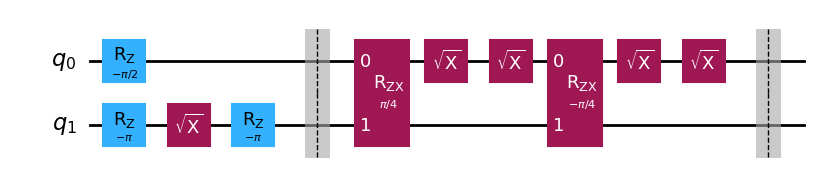

In [5]:
qc = QuantumCircuit(2)
qc.rz(-np.pi/2,0)
qc.rz(-np.pi,1)
qc.sx(1)
qc.rz(-np.pi,1)

qc.barrier()
qc.rzx(np.pi/4,0,1)
qc.sx(0)
qc.sx(0)
qc.rzx(-np.pi/4,0,1)
qc.sx(0)
qc.sx(0)
qc.barrier()
qc.draw(output='mpl')

上記のように，エコーの部分とそうではない部分に分けることができ，$CR_{\pm\pi/4}$のみをキャリブレーションすると，説明したように$ZI$という不要な項が発生してしまいます．そこで，エコーの部分全体をキャリブレーションをして$CR_{\pi/2}$を実現できるようなパルスの振幅を求めていきます．

### エコーの部分のキャリブレーション
よって，以下のエコーの部分のキャリブレーションを行います．

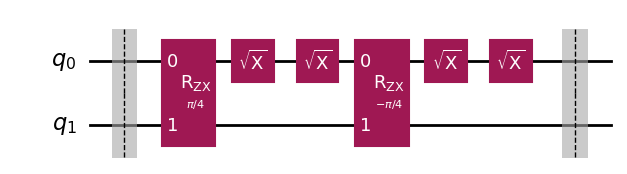

In [6]:
qc = QuantumCircuit(2)
qc.barrier()
qc.rzx(np.pi/4,0,1)
qc.sx(0)
qc.sx(0)
qc.rzx(-np.pi/4,0,1)
qc.sx(0)
qc.sx(0)
qc.barrier()
qc.draw(output='mpl')

$X_{\pi/2}$ (以下の場合だと$\sqrt{X}$)に関しては1量子ビットでキャリブレーションが完了しているためその結果を用いて，$CR_{\pm\theta}$として$\theta$の値を変化させることで$CR_{\pi/2}$を全体として実現できるような$\theta \propto  V_0 (振幅))$を求めていきます．<br>
なお，先ほど説明したように$CR_{\theta}$の実現方法は
```{admonition} CRゲートの実現方法
1つ目の量子ビット(制御量子ビット)に対して$\omega_d = \tilde{\omega}_2$,$\phi=0$となる次のパルスを打ちます．
\begin{align}
V_1(t) =  A(t)\sin(\tilde{\omega}_2 t)
\end{align}
そして，キャリブレーションを行い，$CR_{\theta}$が実現できるパルスの振幅を記録します．
```
です．
```{admonition} 筆者が当初分からなかったこと
:class: tip,dropdown
制御量子ビットに対してパルスを当てているはずであるのに制御量子ビットは特に影響を受けるわけではなくコントロール量子ビットが$0,1$反転する場合があるのが不思議でたまりませんした．しかしこれは全く直感に反するような話ではなありません．制御量子ビットに制御量子ビットの周波数ではない周波数を当てても制御量子ビットは$0,1$を反転させることはありません．逆に制御量子ビットの周波数と同じ周波数のパルスを当てると1量子ビットで議論したのと同様に$0,1$を反転させる場合があります．このように特定の周波数のみに影響を受けやすいことを**共鳴**と言います．言い換えれば共鳴しない周波数を当てても何も影響を及ぼさないのです．
```


#### 周波数に関して
まず考えなくてはいけないのは制御量子ビットに当てるパルスの周波数です．実装の理論では，制御量子ビットに$\tilde{\omega}$の周波数を当てましたが，$\tilde{\omega}$は
\begin{align}
\tilde{\omega}_2 =  \omega_2 + \frac{g^2}{\hbar^2\Delta} 
\end{align}
であり，二つの量子ビットの接続係数である$g$という値が必要で$\tilde{\omega}$を見つけるのは簡単ではありません．そこで，そもそも量子ビットの周波数は$GHz$という高周波数であるため，**二つの量子ビットの周波数の差は十分に大きい**という近似をすることができます．つまり，$\Delta$が十分に大きくなるため，
\begin{align}
\tilde{\omega}_2 \sim \omega_2
\end{align}
という荒い近似を行うことができるのです．また，この近似によって，制御量子ビットに$\omega_2$の周波数のパルスを当てても，$\omega_2$は制御量子ビットの周波数である$\omega_1$とは十分に離れているため制御量子ビットはパルスによる影響で$|0\rangle$から$|1\rangle$に遷移してしまうなどの影響が少なくなります．

#### バックエンドを定義する．
1量子ビットの際と同様のバックエンドを使用します．

In [7]:
# バックエンドのモデル
ibm_backend = Fake7QPulseV1()

# 使用するソルバー

qubits_to_model = [0,1,2,3,4]
solver_options = {
    "method": "jax_odeint",
    "atol": 1e-6,
    "rtol": 1e-8,
    "hmax": ibm_backend.configuration().dt}
    
# 数値計算を行うバックエンド
backend = DynamicsBackend.from_backend(
    backend=ibm_backend,
    subsystem_list=qubits_to_model,
    solver_options=solver_options,
    )

#### バックエンドからデフォルトの周波数を取り出す．
パルスを送信するためには各量子ビットの周波数である$\omega_1,\omega_2$の値が必要でした．1番目に割り当てられている量子ビット(量子ビット0)と，2番目に割り当てられている量子ビット(量子ビット1)の周波数を取り出すと以下の通りになります．

In [8]:
backend_defaults = ibm_backend.defaults()

# 単位の定義
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9

# 以下の量子ビットについて量子ビット周波数を探索する
qubit1 = 0
qubit2 = 1

# 量子ビット0に関しての周波数を取り出す．
center_frequency1_Hz = backend_defaults.qubit_freq_est[qubit1] 
center_frequency2_Hz = backend_defaults.qubit_freq_est[qubit2] 
print(f"量子ビット{qubit1}は {center_frequency1_Hz / GHz}GHz の周波数です．")
print(f"量子ビット{qubit2}は {center_frequency2_Hz / GHz}GHz の周波数です．")

量子ビット0は 5.260483791030155GHz の周波数です．
量子ビット1は 5.170333454748703GHz の周波数です．


#### パルスの形を決定する．
必要となるパルスは次の三種類です．
- 量子ビット0に打つ$X_{\pi/2}$ゲートのパルス(1量子ビットのセクションにてキャリブレーションが完了している．)
- 量子ビット0に打つ$CR_{\pi/4}$ゲートのパルス
- 量子ビット0に打つ$CR_{-\pi/4}$ゲートのパルス

それぞれのパルスでは$\sigma,t_f,\phi$の値は共通であり1量子ビットと同様にします：

In [9]:
sigma = 0.015 * us
t_f = sigma * 8
phi = 0

$X_{\pi/2}$ゲートの周波数は$\omega_d = \omega_1$で，振幅は1量子ビットでキャリブレーションから得られた値である(0.03075875030230344
)を使用します：

In [10]:
x90_amp= 0.03075875030230344

そして，$CR_{\pm\pi/4}$に関しては周波数は$\omega_d = \omega_2$で振幅は，$0~\pm 2$の値で変化させて実験を行います．しかし，Qiskitの特性上振幅は$1$が限界であるため，それぞれ$0~\pm 1$の値で変化させたパルスを二回作用させることで$0~\pm 2$の値で変化させて実験できるようにします．

In [11]:
V_0_min = 0
V_0_max = 1.0
num_cr_points = 200
V_0 = np.linspace(V_0_min, V_0_max, num_cr_points)

#### パルスを設定する．
$X_{\pi/2}$のパルスは以下の通りです．

In [12]:
with pulse.build(backend=backend, default_alignment='sequential', name='x90') as x90_sched:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit1)
    pulse.set_frequency(center_frequency1_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=x90_amp,
                              sigma=drive_sigma,
                              name='x90'), drive_chan)

$CR_{\pm\pi/4}$に関しては次の通りです．それぞれのゲートの違いは，振幅の$\pm$です．$CR_{\pi/4}$は振幅が$+$，$CR_{-\pi/4}$は振幅が$-$になります．

In [13]:
# 振幅をパラメータとして登録する．
drive_amp = Parameter('drive_amp')

# CR_pi/4
with pulse.build(backend=backend, default_alignment='sequential', name='Rzx Experiment plus') as rzx_sched_plus:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit1)
    pulse.set_frequency(center_frequency2_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              # パルスの振幅がプラス
                              sigma=drive_sigma,
                              name='Rzx_pi/4'), drive_chan)

# CR_-pi/4
with pulse.build(backend=backend, default_alignment='sequential', name='Rzx Experiment minus') as rzx_sched_minus:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit1)
    pulse.set_frequency(center_frequency2_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              # パルス振幅がマイナス
                              amp=-drive_amp,
                              sigma=drive_sigma,
                              name='Rzx_-pi/4'), drive_chan)

#### 量子回路を作成する．
今回のキャリブレーションでは，(1)初期状態を$|00\rangle$として(2)量子ビット0に$CR_{\pi/4}$のパルスを二回当てて(3)量子ビット0に$X_{\pi/2}$のパルスを二回あてて，(4)量子ビット0に$CR_{-\pi/4}$のパルスを二回当てて(5)量子ビット0に$X_{\pi/2}$のパルスを二回あてて，(6)量子ビット0と量子ビット1を同時に測定します．

In [14]:
# パルスに対応するカスタムゲートを作成する．
rzx_gate_plus = Gate("rzx_plus", 1, [drive_amp])
rzx_gate_minus = Gate("rzx_minus", 1, [drive_amp])
x90 = Gate("x90", 1, [])


# 量子回路を作成 今回は2つの量子ビットが必要
qc_rzx = QuantumCircuit(2)

# 初期状態は|0>であるため(2)を行う
qc_rzx.append(rzx_gate_plus, [0])
qc_rzx.append(rzx_gate_plus, [0])
# (3)
qc_rzx.append(x90, [0])
qc_rzx.append(x90, [0])
# (4)
qc_rzx.append(rzx_gate_minus, [0])
qc_rzx.append(rzx_gate_minus, [0])
# (5)
qc_rzx.append(x90, [0])
qc_rzx.append(x90, [0])
# (6)
qc_rzx.measure_all()

#################################
# バックエンドの設定
qc_rzx.add_calibration(rzx_gate_plus, (0,), rzx_sched_plus, [drive_amp])
qc_rzx.add_calibration(rzx_gate_minus, (0,), rzx_sched_minus, [drive_amp])
exp_rzx_circs = [qc_rzx.assign_parameters({drive_amp: a}, inplace=False) for a in V_0]
backend.target.add_instruction(
    rzx_gate_plus,
    {(0,): InstructionProperties(calibration=rzx_sched_plus)},
)
backend.target.add_instruction(
    rzx_gate_minus,
    {(0,): InstructionProperties(calibration=rzx_sched_minus)},
)

backend.target.add_instruction(
    x90,
    {(0,): InstructionProperties(calibration=x90_sched)},
)

量子回路は以下のようになります．

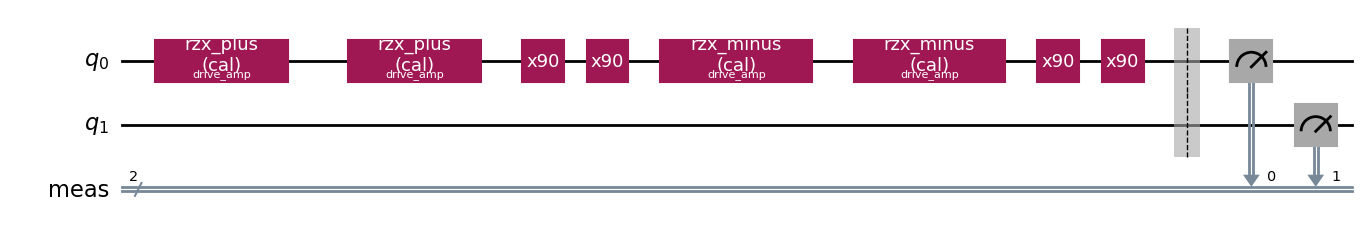

In [15]:
qc_rzx.draw('mpl')

パルスは以下のようになり，量子ビット0のみにパルスを当てていることが分かります．

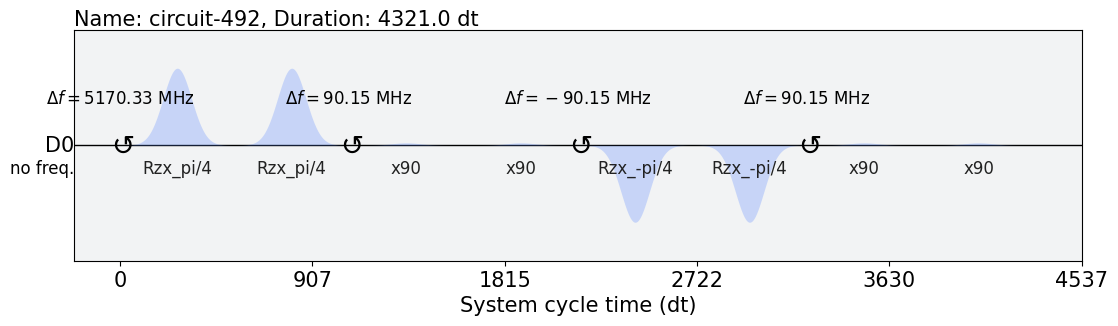

In [16]:
exp_rzx_schedule = schedule(exp_rzx_circs[-1], backend)
exp_rzx_schedule.draw()

#### シミュレーションを行う．
各振幅で500回測定を行いその平均値を返すとします．(以下のコードのnum_shots_per_pointが各振幅での測定回数でmeas_return='avg’で平均値を返すようにしています．)

In [17]:
import warnings
warnings.filterwarnings('ignore')

num_shots_per_point = 500
job = backend.run(exp_rzx_circs,
            meas_level=2,
            meas_return='avg',
            shots=num_shots_per_point)
job_monitor(job)

Job Status: job has successfully run


#### 結果を表示してキャリブレーションを完了する．
シミュレーションが終わったので結果を表示します．まずはそれぞれ$00,01,10,11$の得られた確率を表示します．

In [18]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly
from IPython.display import display, HTML


result = job.result()
list_00 = []
list_01 = []
list_10 = []
list_11 = []

for i in range(num_cr_points):
    # Qiskit 上での01などの順序はこの教材とは逆順になっていることに注意する．
    list_00.append(result.get_memory(i).count('00')/num_shots_per_point)
    list_01.append(result.get_memory(i).count('10')/num_shots_per_point)
    list_10.append(result.get_memory(i).count('01')/num_shots_per_point)
    list_11.append(result.get_memory(i).count('11')/num_shots_per_point)

layout = go.Layout(
    font_size=15,  # グラフ全体のフォントサイズ
)

fig = go.Figure(layout=layout)
plot =[
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=list_00,
                             mode='lines',
                             name=r'$|00\rangle$'
                            )
                  ),
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=list_01,
                             mode='lines',
                             name=r'$|01\rangle$',
                            )
                  ),
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=list_10,
                             mode='lines',
                             name=r'$|10\rangle$',
                            )
                  ),
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=list_11,
                             mode='lines',
                             name=r'$|11\rangle$',
                            )
                  )
]

fig.update_layout(
    xaxis_title=r"振幅$V_0$",
    yaxis_title="確率",
    font=dict(
        family="Meiryo",
        size=15
    )
)
fig.write_html("../../../animation/quantum_gate_2_plot1.html",include_mathjax ="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js")

<div style="position:relative;padding-bottom:60%;">
    <!-- 56.25 comes from aspect ratio of 16:9, change this accordingly -->
    <iframe
        style="width:100%;height:100%;position:absolute;left:0px;top:0px;"
        frameborder="0"
        width="100%"
        height="100%"
        allowfullscreen
        allow="autoplay"
        src="../../../animation/quantum_gate_2_plot1.html">
    </iframe>
</div>

$CR_{\theta}$ゲートは初期状態$|00\rangle$に対して行列指数関数の性質2より
\begin{align}
\exp\left( -\frac{i}{2}\theta\sigma_z\otimes\sigma_x \right)|00\rangle &= \left( \cos(\theta/2) \sigma_I\otimes\sigma_I- i\sin(\theta/2)\sigma_z\otimes\sigma_x  \right)|00\rangle\\
&= \cos(\theta/2)|00\rangle -i \sin(\theta/2)|01\rangle
\end{align}
となります．つまり理論的には$|10\rangle,|11\rangle$が出力結果で出てくるわけはなく，数値シミュレーションでもたしかに理論とつじつまが合うような結果が得られています．

以上の結果を$|00\rangle$の場合は$\cos^2(\theta/2)$，$|01\rangle$の場合は$\sin^2(\theta/2)$にフィッティングさせたいのですが，以上の図を見て分かるように振動する範囲があまりに小さいため基本的に三角関数のフィッティングはうまく行きません．そこで直線で近似することにします．

In [19]:
from scipy import optimize

def approximation_expression_00(x,a,b):
    return a*x+b
def approximation_expression_01(x,a,b):
    return a*x+b

popt_00, pcov_00 = optimize.curve_fit(approximation_expression_00, 2*V_0, list_00,p0=[0,0])
popt_01, pcov_01 = optimize.curve_fit(approximation_expression_01, 2*V_0, list_01,p0=[0,1])

fig = go.Figure(layout=layout)
plot =[
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=list_00,
                             mode='lines',
                             name=r'$|00\rangle$'
                            )
                  ),
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=list_01,
                             mode='lines',
                             name=r'$|01\rangle$',
                            )
                  ),
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=approximation_expression_00(2*V_0,popt_00[0],popt_00[1]),
                             mode='lines',
                             name=r'$\text{Fitting:}|00\rangle$',
                            )
                  ),
    fig.add_trace(go.Scatter(x=2*V_0,
                             y=approximation_expression_01(2*V_0,popt_01[0],popt_01[1]),
                             mode='lines',
                             name=r'$\text{Fitting:}|01\rangle$',
                            )
                  ),
]

fig.update_layout(
    xaxis_title=r"振幅$V_0$",
    yaxis_title="確率",
    font=dict(
        family="Meiryo",
        size=15
    )
)
fig.write_html("../../../animation/quantum_gate_2_plot2.html",include_mathjax ="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js")

<div style="position:relative;padding-bottom:60%;">
    <!-- 56.25 comes from aspect ratio of 16:9, change this accordingly -->
    <iframe
        style="width:100%;height:100%;position:absolute;left:0px;top:0px;"
        frameborder="0"
        width="100%"
        height="100%"
        allowfullscreen
        allow="autoplay"
        src="../../../animation/quantum_gate_2_plot2.html">
    </iframe>
</div>

よってそれぞれの直線の交点がちょうど交わる点が$|00\rangle,|01\rangle$が半分の確率づつ得られている振幅であるため，
\begin{align}
\exp\left( -\frac{i}{2}\frac{\pi}{2}\sigma_z\otimes\sigma_x \right)|00\rangle = \frac{1}{\sqrt{2}}|00\rangle -i \frac{1}{\sqrt{2}}|01\rangle
\end{align}
から分かるように，ちょうど$CR_{\pi/2}$が実現できている箇所です．よって，それぞれのフィッティングの直線の交点である

In [20]:
cr_x90_amp = -(popt_01[1]-popt_00[1])/(popt_01[0]-popt_00[0])
cr_x90_amp 

1.3955064635598762

がちょうど$CR_{\pi/2}$を実現する振幅です．ただし今回はQiskitの制約である振幅は1以下を超えるためにあえて二回の$CR_{\pi/2}$ゲートを作用させたため，$CR_{\pi/2}$ゲート一個分の振幅は次の値になります．

In [21]:
cr_x90_amp = cr_x90_amp/2
cr_x90_amp

0.6977532317799381

### キャリブレーションを下にCNOTゲートを作成する．
ここから先はさきほどキャリブレーションを行った振幅を下に新しいCNOTゲートを作成します．エコーの部分のキャリブレーションが終わったため，エコー以外の部分を足し合わせるだけです．<br>
まずはエコーの部分のパルスをさきほどの求めた振幅を使用して作成しましょう！
#### パルスの作成
$X_{\pi}/2,CR_{\pi/2}$を実現するパルスは以下の通りです．

In [22]:
cr_x90_amp=0.6973115904518858

In [23]:
# x90
with pulse.build(backend=backend, default_alignment='sequential', name='x90') as x90_sched_0:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit1)
    pulse.set_frequency(center_frequency1_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=x90_amp,
                              sigma=drive_sigma,
                              name='x90'), drive_chan)

# CR_pi/4
with pulse.build(backend=backend, default_alignment='sequential', name='cnot Experiment plus') as cnot_sched_plus:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit1)
    pulse.set_frequency(center_frequency2_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              # パルスの振幅がプラス
                              amp=cr_x90_amp,
                              sigma=drive_sigma,
                              name='cnot_pi/4'), drive_chan)

# CR_-pi/4
with pulse.build(backend=backend, default_alignment='sequential', name='cnot Experiment minus') as cnot_sched_minus:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit1)
    pulse.set_frequency(center_frequency2_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              # パルス振幅がマイナス
                              amp=-cr_x90_amp,
                              sigma=drive_sigma,
                              name='cnot_-pi/4'), drive_chan)

そして，初期状態を$|10\rangle$とします．理想的には
\begin{align}
CNOT|10\rangle = |11\rangle
\end{align}
となるはずです．量子回路をセットアップする工程に移りたいのですがQiskit上でパルスレベルで作成したゲートとパルスレベルで定義していないデフォルトのゲートのハイブリッドのシミュレーションを行うことはできません．(まだ確かめていませんが実機ではすべてのゲートがパルスに変換されるため可能だと思います．)　つまり，$Z_{\theta}$ゲートや$S_X$ゲートなどをすべて定義する必要があります．<br>
$Z_{\theta}$ゲートに関しては位相$\phi$をずらすことに相当したため以下で定められます．

In [24]:
# RX
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(-phi, pulse.DriveChannel(0))

with pulse.build() as rz1:
    pulse.shift_phase(-phi, pulse.DriveChannel(1))

そして，$S_X$ゲートに関しては量子ビット0は前のセクションでキャリブレーションを行いましたが量子ビット1はまだ行っていなかったため同様のキャリブレーションを行い，量子ビット1用のパルスを生成すると以下の通りになります．

In [25]:
# 以下の量子ビットについて量子ビット周波数を探索する
qubit2 = 1
center_frequency2_Hz = backend_defaults.qubit_freq_est[qubit2] 
V_0_min = 0
V_0_max = 0.3
num_x90_points = 200

V_0 = np.linspace(V_0_min, V_0_max, num_x90_points)

sigma = 0.015 * us
t_f = sigma * 8
phi = 0
drive_amp = Parameter('drive_amp')

# パルスを設定する．
with pulse.build(backend=backend, default_alignment='sequential', name='x90_calibration') as x90_calibration_sched:

    drive_chan = pulse.drive_channel(qubit2)
    # t_f
    drive_duration = pulse.seconds_to_samples(t_f)
    # sigma
    drive_sigma = pulse.seconds_to_samples(sigma)
    # 周波数
    pulse.set_frequency(center_frequency2_Hz, drive_chan)
    # 位相
    pulse.set_phase(phi,drive_chan)

    # パルスを打つ
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_calibration'), drive_chan)

x90_calibration = Gate("x90_calibration", 1, [drive_amp])
qc_x90_calibration = QuantumCircuit(1)
qc_x90_calibration.append(x90_calibration, [0])
qc_x90_calibration.measure_all()

######################################
qc_x90_calibration.add_calibration(x90_calibration, (0,), x90_calibration_sched, [drive_amp])
exp_x90_calibration_circs = [qc_x90_calibration.assign_parameters({drive_amp: a}, inplace=False) for a in V_0]
backend.target.add_instruction(
    x90_calibration,
    {(0,): InstructionProperties(calibration=x90_calibration_sched)},
)
num_shots_per_point = 500
job = backend.run(exp_x90_calibration_circs,
            meas_level=2,
            meas_return='avg',
            shots=num_shots_per_point)

result = job.result()
zero_list = []
one_list = []

for i in range(200):
    zero_list.append(result.get_memory(i).count('0')/500)
    one_list.append(result.get_memory(i).count('1')/500)

from scipy import optimize

def approximation_expression(x,a,b):
    return 0.5*np.sin(a*x+b)+0.5

popt, pcov = optimize.curve_fit(approximation_expression, V_0, zero_list,p0=[60,0])

x90_1_amp = np.pi/(2*popt[0])
print(f"量子ビット{qubit2}のSXゲートの振幅は{x90_1_amp}です．")

量子ビット1のSXゲートの振幅は0.02971316588429983です．


よってこの振幅を利用して量子ビット1用の$S_X$ゲートのパルスを作ると以下のようになります．．

In [26]:
with pulse.build(backend=backend, default_alignment='sequential', name='x90_1') as x90_sched_1:
    drive_duration = pulse.seconds_to_samples(t_f)
    drive_sigma = pulse.seconds_to_samples(sigma)
    drive_chan = pulse.drive_channel(qubit2)
    pulse.set_frequency(center_frequency2_Hz, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=x90_1_amp,
                              sigma=drive_sigma,
                              name='x90_1'), drive_chan)

ようやく回路を構築する準備が整いました。細かいコードは以下の展開式の部分で見ていただき全体の回路は以下の通りです．

In [27]:
# バックエンドの定義
ibm_backend = Fake7QPulseV1()

# 使用するソルバー
qubits_to_model = [0,1,2,3,4]
solver_options = {
    "method": "jax_odeint",
    "atol": 1e-6,
    "rtol": 1e-8,
    "hmax": ibm_backend.configuration().dt}
    
# 数値計算を行うバックエンド
backend = DynamicsBackend.from_backend(
    backend=ibm_backend,
    subsystem_list=qubits_to_model,
    solver_options=solver_options,
    )

# パルスに対応するカスタムゲートを作成する．
cnot_gate_plus = Gate("cnot_plus", 1, [])
cnot_gate_minus = Gate("cnot_minus", 1, [])
x90 = Gate("x90", 1, [])

# 量子回路を作成 今回は2つの量子ビットが必要
qc_cnot = QuantumCircuit(2)

# 初期状態を生成
qc_cnot.sx(0)
qc_cnot.sx(0)

qc_cnot.barrier()

###### 以下はエコー以外の部分
# この部分をうまくできないかを考えてみる．
qc_cnot.rz(-np.pi/2,0)
qc_cnot.rz(-np.pi,1)
qc_cnot.sx(1)
qc_cnot.rz(-np.pi,1)

qc_cnot.barrier()
###### 以下はエコーの部分
# 初期状態は|0>であるため(2)を行う
qc_cnot.append(cnot_gate_plus, [0])
qc_cnot.append(cnot_gate_plus, [0])
# (3)
qc_cnot.sx(0)
qc_cnot.sx(0)
# (4)
qc_cnot.append(cnot_gate_minus, [0])
qc_cnot.append(cnot_gate_minus, [0])
# (5)
qc_cnot.sx(0)
qc_cnot.sx(0)
# (6)
qc_cnot.measure_all()

######### それぞれのゲートをパルスと結びつける
backend.target.add_instruction(
    cnot_gate_plus,
    {(0,): InstructionProperties(calibration=cnot_sched_plus)},
)
backend.target.add_instruction(
    cnot_gate_minus,
    {(0,): InstructionProperties(calibration=cnot_sched_minus)},
)
# SXゲートを新たに定義した．
backend.target.add_instruction(
    SXGate(),
    {(0,): InstructionProperties(calibration=x90_sched),(1,):InstructionProperties(calibration=x90_sched_1)},
)

backend.target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

図示すると以下の通りです．

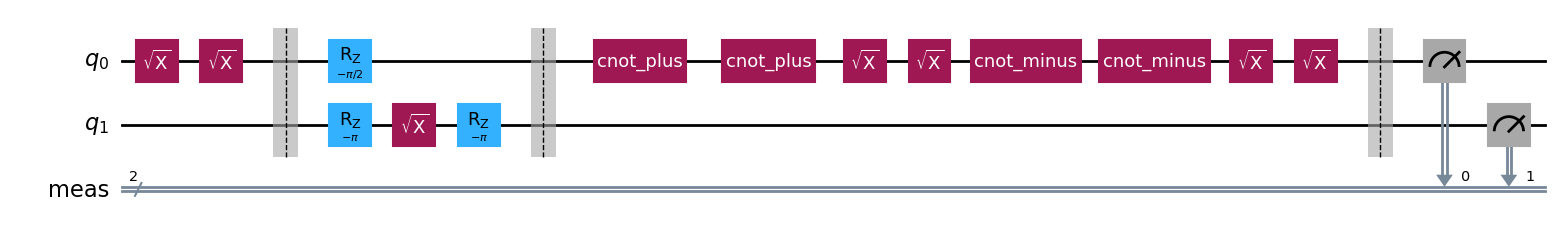

In [28]:
qc_cnot.draw('mpl')

そしてシミュレーションを実行し結果を表示します．

In [29]:
import warnings
warnings.filterwarnings('ignore')

num_shots_per_point = 500
job = backend.run(qc_cnot,
            meas_level=2,
            meas_return='avg',
            shots=num_shots_per_point)
job = job.result()
job.get_counts(0)

{'00': 2, '01': 57, '10': 1, '11': 440}

以上の結果のようにたしかに$|11\rangle$が高確率で得られることが分かりました！！！！！以上より数値シミュレーションによってCNOTゲートを自作することができました！